<a href="https://colab.research.google.com/github/mlerma54/adversarial-attacks-on-saliency-maps/blob/main/presoftmax_adversarial_attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pre-Softmax Adversarial Attacks**

# Example of how to fool gradient-based attribution methods (like Grad-CAM) that use pre-softmax outputs.

# Version of the code for public posting

In [1]:
# code version
ver='2023-07-06a'
print('code version:',ver)

code version: 2023-07-06a


In [2]:
from datetime import date

today = date.today()
print("Today's date:", today)

Today's date: 2023-07-06


In [3]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# this is to time execution time
!pip install ipython-autotime
%load_ext autotime

time: 321 µs (started: 2023-07-06 19:35:25 +00:00)


In [5]:
# Make sure that we use tensorflow 2
%tensorflow_version 2.x
import tensorflow
print('TensorFlow version:', tensorflow.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
TensorFlow version: 2.12.0
time: 3.24 s (started: 2023-07-06 19:35:25 +00:00)


# <font color="red">Please give below paths as per the paths in your system</font>

In [6]:
root = '/content/gdrive/My Drive/adversarial-attacks-on-saliency-maps/'
images_dir = root + 'images/'
plots_dir = root + 'plots/'

time: 405 µs (started: 2023-07-06 19:35:29 +00:00)


In [7]:
import os

for d in [root, images_dir]:
  print(d)
  assert(os.path.isdir(d))

/content/gdrive/My Drive/adversarial-attacks-on-saliency-maps/
/content/gdrive/My Drive/adversarial-attacks-on-saliency-maps/images/
time: 1.83 ms (started: 2023-07-06 19:35:29 +00:00)


# **Load Packages**

In [8]:
# import the necessary packages
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np

from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions

from tensorflow.keras.layers import InputLayer, Lambda, Add

from tensorflow.keras.losses import SparseCategoricalCrossentropy # as a class (performs sum over batch reduction by default)
from tensorflow.keras.losses import sparse_categorical_crossentropy # as a function - see: https://keras.io/api/losses/#standalone-usage-of-losses

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
#from tensorflow.keras.applications import imagenet_utils
import numpy as np
import imutils
import cv2

from PIL import Image

from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt


time: 32.1 ms (started: 2023-07-06 19:35:29 +00:00)


# Load pretrained VGG19 model

In [9]:
# initialize the model to be VGG19

# load the pre-trained CNN from disk
print("[INFO] loading model...")
model = VGG19(weights="imagenet", classifier_activation=None) # <- DON'T INCLUDE FINAL SOFTMAX !!!
model.summary()

[INFO] loading model...
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 5

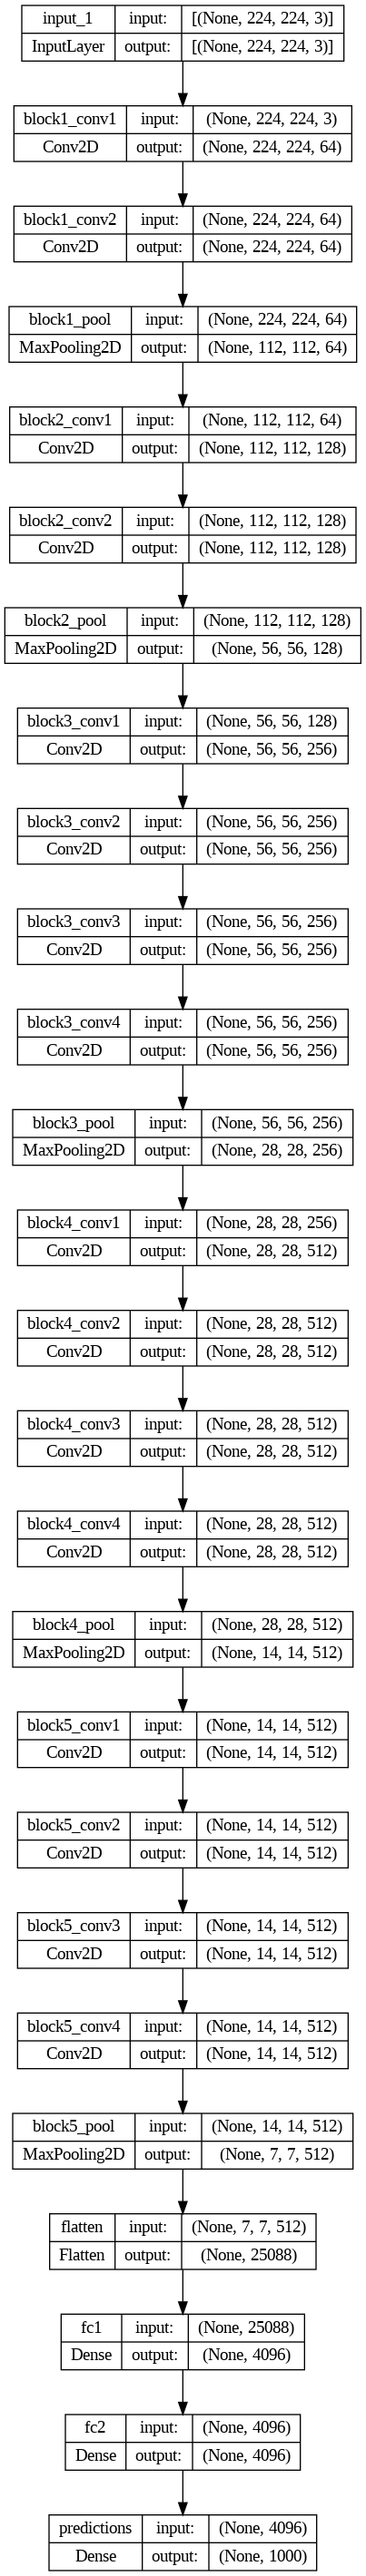

time: 140 ms (started: 2023-07-06 19:35:32 +00:00)


In [10]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [11]:
IMAGE_SIZE_1, IMAGE_SIZE_2, IMAGE_SIZE_3 = model.input.shape[1:]
INPUT_SHAPE = (IMAGE_SIZE_1, IMAGE_SIZE_2, IMAGE_SIZE_3)
IMAG_SIZE = (IMAGE_SIZE_1, IMAGE_SIZE_2)
print(INPUT_SHAPE, IMAG_SIZE)

(224, 224, 3) (224, 224)
time: 832 µs (started: 2023-07-06 19:35:32 +00:00)


# Create modified model.

We do this by cloning the original model and, in the process, inserting a lambda layer connecting the selected area of the last pooling layer to the presoftmax output ("predictions") layer.

In [12]:
# Modified model
# Add a direct branch from a unit of 'block5_pool' layer to the predictions layer

input_layer = InputLayer(input_shape = INPUT_SHAPE)

for i, l in enumerate(model.layers):

  #print('{:3} {:12} {} {}'.format(i, l.name, l.trainable, len(l.trainable_variables))) # for debugging

  if i == 0:

    x = input_layer.output

  else:

    config = l.get_config()
    weights = l.get_weights()
    cloned_layer = type(l).from_config(config)
    cloned_layer.build(l.input_shape)
    cloned_layer.set_weights(weights)


    if cloned_layer.name == 'block5_pool':

      x = cloned_layer(x)

      lambda_layer = Lambda(lambda t:
                            tf.reduce_sum(t[:,0,0,:] * t[:,0,0,:], axis=-1, keepdims=True) * 10, name='lambda') # <- left upper area enhanced

      x1 = lambda_layer(x)

    elif cloned_layer.name == 'predictions':

      x = cloned_layer(x)

      x = Add(name='add')([x,x1]) # <- this should mofify the logits (presoftmax outputs) but not the postsofmax outputs

    else:

      x = cloned_layer(x)

new_model = Model(inputs=[input_layer.input], outputs=[x], name=model.name+'_new')

time: 898 ms (started: 2023-07-06 19:35:32 +00:00)


In [13]:
new_model.summary()

Model: "vgg19_new"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                         

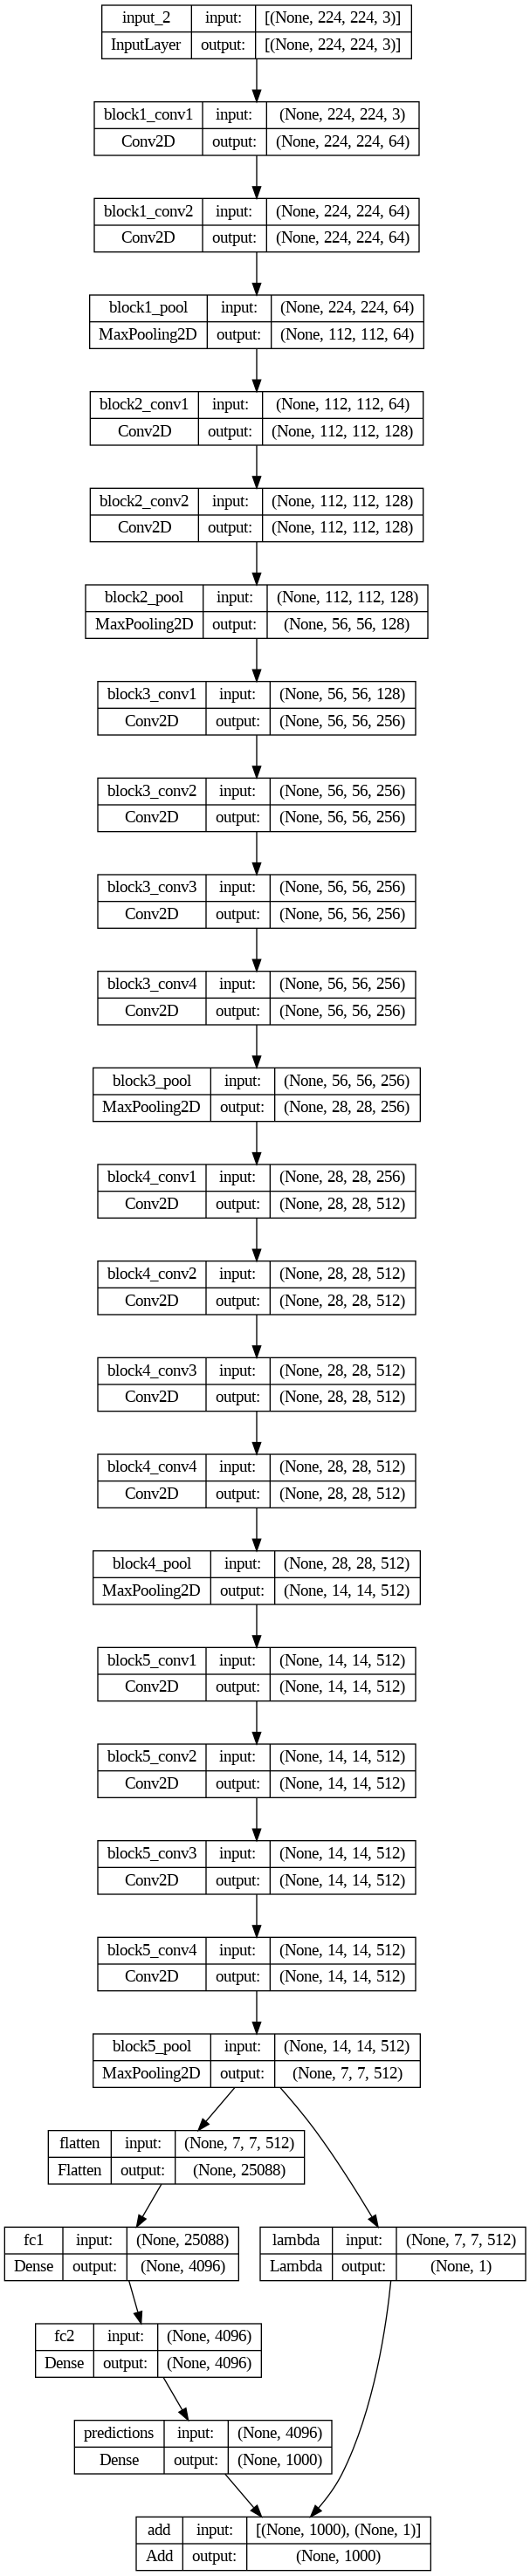

time: 182 ms (started: 2023-07-06 19:35:33 +00:00)


In [14]:
plot_model(new_model, to_file='new_model.png', show_shapes=True, show_layer_names=True)

In [15]:
# Grad-CAM implementation from:
# https://www.pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/
# (without the guided gradients section, and with an option to add a final softmax)

class GradCAM:
  def __init__(self, model, classIdx=None, layerName=None, add_softmax=False): # <- do not add softmax by default
    # store the model, the class index used to measure the class
    # activation map, and the layer to be used when visualizing
    # the class activation map
    self.model = model
    self.classIdx = classIdx
    self.layerName = layerName
    self.add_softmax = add_softmax

    # if the layer name is None, attempt to automatically find
    # the target output layer
    if self.layerName is None:
      self.layerName = self.find_target_layer()

    # construct our gradient model by supplying (1) the inputs
    # to our pre-trained model, (2) the output of the (presumably)
    # final 4D layer in the network, and (3) the output of the
    # softmax activations from the model
    self.gradModel = tensorflow.keras.models.Model(inputs=[self.model.inputs],
                          outputs=[self.model.get_layer(self.layerName).output,
                                   self.model.output])

  def find_target_layer(self):
    # attempt to find the final convolutional layer in the network
    # by looping over the layers of the network in reverse order
    for layer in reversed(self.model.layers):
      # check to see if the layer has a 4D output
      if len(layer.output_shape) == 4:
        return layer.name

    # otherwise, we could not find a 4D layer so the GradCAM
    # algorithm cannot be applied
    raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

  #def compute_heatmap(self, image, classIdx=None, eps=1e-8):
  def compute_heatmap(self, image, classIdx=None, eps=0):

    if classIdx == None:
      classIdx = self.classIdx

    if classIdx == None:
      raise ValueError("No classIdx provided. Cannot compute heatmap.")

    # record operations for automatic differentiation
    with tf.GradientTape() as tape:
      # cast the image tensor to a float-32 data type, pass the
      # image through the gradient model, and grab the loss
      # associated with the specific class index
      inputs = tf.cast(image, tf.float32)
      (convOutputs, predictions) = self.gradModel(inputs)

      if self.add_softmax: # add final softmax if 'add_softmax' is True
        loss = tf.nn.softmax(predictions,axis=-1)[:, classIdx]
      else:
        loss = predictions[:, classIdx]

    # use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)

    '''
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    '''

    # the convolution and guided gradients have a batch dimension
    # (which we don't need) so let's grab the volume itself and
    # discard the batch
    convOutputs = convOutputs[0]
    #guidedGrads = guidedGrads[0]

    # compute the average of the gradient values, and using them
    # as weights, compute the ponderation of the filters with
    # respect to the weights
    weights = tf.reduce_mean(grads, axis=(0, 1))
    #weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
    cam = tf.nn.relu(cam)

    # grab the spatial dimensions of the input image and resize
    # the output class activation map to match the input image
    # dimensions
    (w, h) = (image.shape[2], image.shape[1])
    raw_heatmap = cv2.resize(cam.numpy(), (w, h))

    # normalize the heatmap such that all values lie in the range
    # [0, 1], scale the resulting values to the range [0, 255],
    # and then convert to an unsigned 8-bit integer
    numer = raw_heatmap - np.min(raw_heatmap)
    denom = (raw_heatmap.max() - raw_heatmap.min()) + eps
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")

    # return class activation map and heatmap to the calling function
    return cam, heatmap # <- convOutputs, cam added 5/5/2021-5/6/2021

time: 1.3 ms (started: 2023-07-06 19:35:34 +00:00)


In [16]:
def overlay_heatmap(heatmap,image,alpha=0.5,colormap=cv2.COLORMAP_JET):

  '''
  apply the supplied color map to the heatmap,
  then overlay the heatmap on the input image
  '''

  heatmap = cv2.applyColorMap(heatmap, colormap) # produce colormap
  heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) # convert to RGB
  output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

  # return a 2-tuple of the color mapped heatmap and the output, overlaid image
  return (heatmap, output)

time: 540 µs (started: 2023-07-06 19:35:34 +00:00)


In [17]:
# list of layers where we may want to apply grad-cam - (listed from input to output)
# make your pcik if you wish to experiment

layer_names = ['block1_pool', 'block2_pool', 'block3_pool', 'block4_pool', 'block5_pool'] # last pool layer of each block
#layer_names = ['block1_conv2', 'block2_conv2', 'block3_conv4', 'block4_conv4', 'block5_conv4'] # last convolutional layer of each block

time: 323 µs (started: 2023-07-06 19:35:34 +00:00)


In [18]:
# Instantiate GradCAM for each layer
logits_gradcam_dict = dict()
postsoftmax_gradcam_dict = dict()
new_logits_gradcam_dict = dict()
new_postsoftmax_gradcam_dict = dict()

for layerName in layer_names:
  logits_gradcam_dict[layerName] = GradCAM(model, layerName=layerName, add_softmax=False)
  postsoftmax_gradcam_dict[layerName] = GradCAM(model, layerName=layerName, add_softmax=True)
  new_logits_gradcam_dict[layerName] = GradCAM(new_model, layerName=layerName, add_softmax=False)
  new_postsoftmax_gradcam_dict[layerName] = GradCAM(new_model, layerName=layerName, add_softmax=True)

time: 68.3 ms (started: 2023-07-06 19:35:34 +00:00)


In [19]:
# pick the layer
#layerName = 'block5_conv4'
layerName = 'block5_pool'

time: 364 µs (started: 2023-07-06 19:35:34 +00:00)


---

# Display Heatmaps

In [20]:
def display_heatmaps(orig_image,layerName,top_pred=0, save_plot=False, plot_name='my_plot'):

    '''
    inputs are:
    - orig_image = the original image
    - layerName = name of the layer used to generate the heatmap
    - top_pred = which class we what to locate starting a the top predicted,
      i.e., 0 = class with the top (highest) score, 1 = second top, etc.
    - save_plot: whether to save the image ploted (typically has better qyality than a screenshot)
    - my_plot: name for the image saved
    '''

    print('layerName =',layerName)
    print()

    orig_bgr = cv2.imread(orig_image) # cv2 loads in BGR format
    orig_rgb = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB) # transform to RGB

    # load the input image from disk (in Keras/TensorFlow format)
    # and preprocess it
    image = load_img(orig_image, target_size=IMAG_SIZE) # RGB
    image = img_to_array(image)

    image = np.expand_dims(image, axis=0) # make the image a 1-element batch

    image = preprocess_input(image) # default mode: caffe
    # caffe: will convert the images from RGB to BGR,
    # then will zero-center each color channel with respect
    # to the ImageNet dataset, without scaling.

    # use the network to make predictions on the input imag and find
    # the class label index with the largest corresponding probability
    preds = model.predict(image)

    preds2 = new_model.predict(image) # or comparison

    # select the index of the class we want to locate in the image
    i = np.argsort(preds[0])[-1-top_pred].item()

    i2 = np.argsort(preds2[0])[-1-top_pred].item()

    # decode the ImageNet predictions to obtain the human-readable label
    decoded = decode_predictions(preds, top=10)

    probs = tf.nn.softmax([x[2] for x in decoded[0]]).numpy()

    decoded2 = decode_predictions(preds2, top=10)

    probs2 = tf.nn.softmax([x[2] for x in decoded2[0]]).numpy()

    # uncomment next lines if you want to see the top predictions

    print()

    print('Original Model')
    for j in range(len(decoded[0])):
        print('{} - {} - {}'.format(j, decoded[0][j], probs[j]))

    print()

    print('New Model')
    for j in range(len(decoded2[0])):
        print('{} - {} - {}'.format(j, decoded2[0][j], probs2[j]))

    (imagenetID, label, out) = decoded[0][top_pred]
    label = "{}: {:.4f} - {:.4f}%".format(label,out,probs[top_pred])

    (imagenetID2, label2, out2) = decoded2[0][top_pred]
    label2 = "{}: {:.4f} - {:.4f}%".format(label2,out2,probs[top_pred])

    print('image index =', i, i2)
    print()
    print("[INFO] {} - {}".format(label,label2))
    print()


    ############################################################################
    # with original model

    # select logits grad-cam
    logits_gradcam = logits_gradcam_dict[layerName]

    # produce heatmaps
    _, logits_heatmap_gradcam = logits_gradcam.compute_heatmap(image, i)

    # resize the resulting heatmaps to the original input image dimensions
    # and then overlay heatmap on top of the image
    logits_heatmap_gradcam = cv2.resize(logits_heatmap_gradcam, (orig_rgb.shape[1], orig_rgb.shape[0]))
    (logits_heatmap_gradcam, logits_output_gradcam) = overlay_heatmap(logits_heatmap_gradcam, orig_rgb, alpha=0.5)

    # display the original image and resulting heatmap and output image
    logits_output_gradcam = np.vstack([orig_rgb, logits_heatmap_gradcam, logits_output_gradcam])
    logits_output_gradcam = imutils.resize(logits_output_gradcam, height=700)


    # select postsoftmax grad-cam
    postsoftmax_gradcam = postsoftmax_gradcam_dict[layerName]

    # produce heatmaps
    _, postsoftmax_heatmap_gradcam = postsoftmax_gradcam.compute_heatmap(image, i)

    # resize the resulting heatmaps to the original input image dimensions
    # and then overlay heatmap on top of the image
    postsoftmax_heatmap_gradcam = cv2.resize(postsoftmax_heatmap_gradcam, (orig_rgb.shape[1], orig_rgb.shape[0]))
    (postsoftmax_heatmap_gradcam, postsoftmax_output_gradcam) = overlay_heatmap(postsoftmax_heatmap_gradcam, orig_rgb, alpha=0.5)

    # display the original image and resulting heatmap and output image
    postsoftmax_output_gradcam = np.vstack([orig_rgb, postsoftmax_heatmap_gradcam, postsoftmax_output_gradcam])
    postsoftmax_output_gradcam = imutils.resize(postsoftmax_output_gradcam, height=700)

    ############################################################################
    # with new model

    # select logits grad-cam
    new_logits_gradcam = new_logits_gradcam_dict[layerName]

    # produce heatmaps
    _, new_logits_heatmap_gradcam = new_logits_gradcam.compute_heatmap(image, i)

    # resize the resulting heatmaps to the original input image dimensions
    # and then overlay heatmap on top of the image
    new_logits_heatmap_gradcam = cv2.resize(new_logits_heatmap_gradcam, (orig_rgb.shape[1], orig_rgb.shape[0]))
    (new_logits_heatmap_gradcam, new_logits_output_gradcam) = overlay_heatmap(new_logits_heatmap_gradcam, orig_rgb, alpha=0.5)

    # display the original image and resulting heatmap and output image
    new_logits_output_gradcam = np.vstack([orig_rgb, new_logits_heatmap_gradcam, new_logits_output_gradcam])
    new_logits_output_gradcam = imutils.resize(new_logits_output_gradcam, height=700)


    # select postsoftmax grad-cam
    new_postsoftmax_gradcam = new_postsoftmax_gradcam_dict[layerName]

    # produce heatmaps
    _, new_postsoftmax_heatmap_gradcam = new_postsoftmax_gradcam.compute_heatmap(image, i)

    # resize the resulting heatmaps to the original input image dimensions
    # and then overlay heatmap on top of the image
    new_postsoftmax_heatmap_gradcam = cv2.resize(new_postsoftmax_heatmap_gradcam, (orig_rgb.shape[1], orig_rgb.shape[0]))
    (new_postsoftmax_heatmap_gradcam, new_postsoftmax_output_gradcam) = overlay_heatmap(new_postsoftmax_heatmap_gradcam, orig_rgb, alpha=0.5)

    # display the original image and resulting heatmap and output image
    new_postsoftmax_output_gradcam = np.vstack([orig_rgb, new_postsoftmax_heatmap_gradcam, new_postsoftmax_output_gradcam])
    new_postsoftmax_output_gradcam = imutils.resize(new_postsoftmax_output_gradcam, height=700)

    vertical_sep = np.ones((700,10,3)).astype(np.uint8) * 255

    ############################################

    # plot

    FONTSIZE = 15

    to_plot = np.hstack([logits_output_gradcam, new_logits_output_gradcam, vertical_sep, postsoftmax_output_gradcam, new_postsoftmax_output_gradcam])

    print(to_plot.shape)
    print()

    fig = plt.figure(figsize=(10,10))
    plt.imshow(to_plot)

    plt.text(to_plot.shape[1]*0.25,-20,'pre-softmax',  horizontalalignment='center', fontsize=FONTSIZE)
    plt.text(to_plot.shape[1]*0.75,-20,'post-softmax',  horizontalalignment='center', fontsize=FONTSIZE)
    x = np.linspace(0,to_plot.shape[1],9)
    xlabels = ['','original model','','altered model','','original model','','altered model','']
    plt.xticks(x, xlabels, fontsize=FONTSIZE)
    y = np.linspace(0,to_plot.shape[0],7)
    ylabels = ['','image','','heatmap','','overlay','']
    plt.yticks(y, ylabels, rotation='vertical', verticalalignment='center', fontsize=FONTSIZE)


    if save_plot:
      plt.savefig(plots_dir + plot_name)

    plt.show()

    print()


time: 2.33 ms (started: 2023-07-06 19:35:34 +00:00)


# Trying with a few images

layerName = block5_pool

1/1 [==============================] - 0s 198ms/step

Original Model
0 - ('n04254680', 'soccer_ball', 14.7885065) - 0.8613560795783997
1 - ('n03445777', 'golf_ball', 11.618675) - 0.036186158657073975
2 - ('n04118538', 'rugby_ball', 11.221301) - 0.0243200846016407
3 - ('n02799071', 'baseball', 11.2008) - 0.02382657118141651
4 - ('n04540053', 'volleyball', 10.911362) - 0.017838573083281517
5 - ('n03134739', 'croquet_ball', 10.218681) - 0.008923451416194439
6 - ('n09835506', 'ballplayer', 10.184523) - 0.008623785339295864
7 - ('n04409515', 'tennis_ball', 10.146002) - 0.008297906257212162
8 - ('n04039381', 'racket', 10.107234) - 0.007982371374964714
9 - ('n03733281', 'maze', 9.002662) - 0.0026449791621416807

New Model
0 - ('n04254680', 'soccer_ball', 521845.56) - 0.8606952428817749
1 - ('n03445777', 'golf_ball', 521842.4) - 0.0366528257727623
2 - ('n04118538', 'rugby_ball', 521842.0) - 0.02441604621708393
3 - ('n02799071', 'baseball', 521841.97) - 0.02366484142839

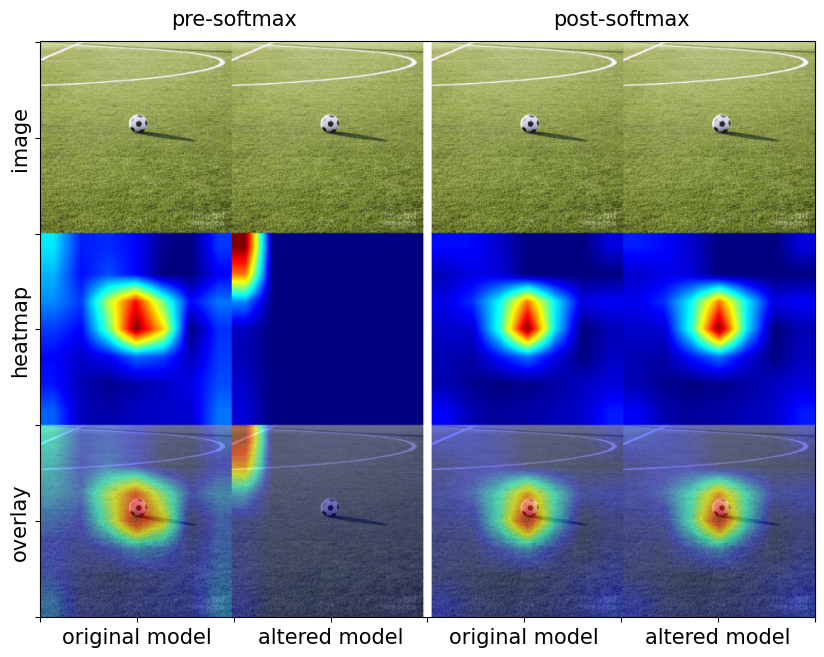


time: 5.34 s (started: 2023-07-06 19:35:34 +00:00)


In [21]:

orig_image = images_dir + 'soccer_ball.jpg'
orig_image
display_heatmaps(orig_image,layerName, save_plot=True, plot_name='soccer_plot.png')


layerName = block5_pool

1/1 [==============================] - 0s 23ms/step

Original Model
0 - ('n04254680', 'soccer_ball', 14.7885065) - 0.8613560795783997
1 - ('n03445777', 'golf_ball', 11.618675) - 0.036186158657073975
2 - ('n04118538', 'rugby_ball', 11.221301) - 0.0243200846016407
3 - ('n02799071', 'baseball', 11.2008) - 0.02382657118141651
4 - ('n04540053', 'volleyball', 10.911362) - 0.017838573083281517
5 - ('n03134739', 'croquet_ball', 10.218681) - 0.008923451416194439
6 - ('n09835506', 'ballplayer', 10.184523) - 0.008623785339295864
7 - ('n04409515', 'tennis_ball', 10.146002) - 0.008297906257212162
8 - ('n04039381', 'racket', 10.107234) - 0.007982371374964714
9 - ('n03733281', 'maze', 9.002662) - 0.0026449791621416807

New Model
0 - ('n04254680', 'soccer_ball', 521845.56) - 0.8606952428817749
1 - ('n03445777', 'golf_ball', 521842.4) - 0.0366528257727623
2 - ('n04118538', 'rugby_ball', 521842.0) - 0.02441604621708393
3 - ('n02799071', 'baseball', 521841.97) - 0.023664841428399

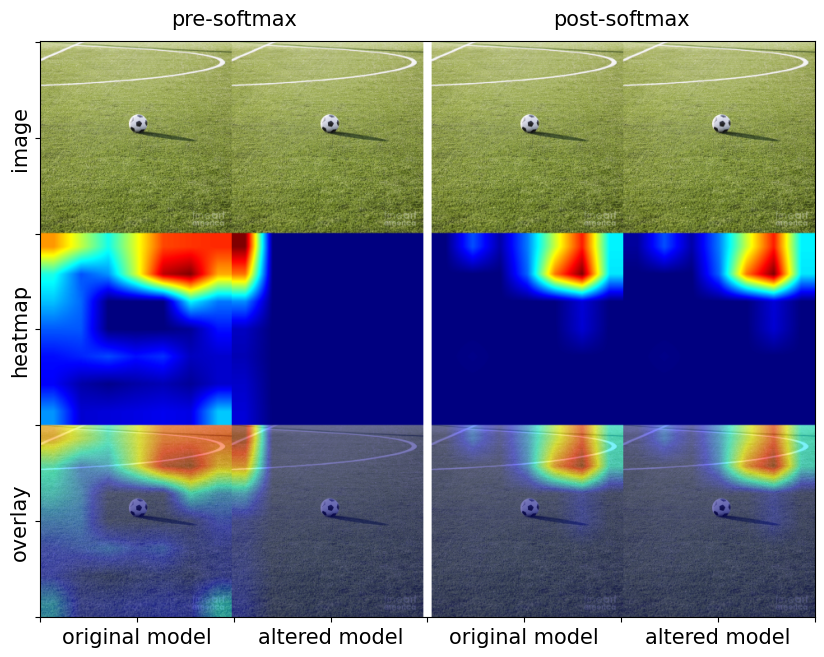


time: 1.3 s (started: 2023-07-06 19:35:39 +00:00)


In [22]:

orig_image = images_dir + 'soccer_ball.jpg'
orig_image
display_heatmaps(orig_image,layerName,top_pred=9, save_plot=True, plot_name='maze_plot.png')


layerName = block5_pool

1/1 [==============================] - 0s 22ms/step

Original Model
0 - ('n02108422', 'bull_mastiff', 11.514912) - 0.6811648607254028
1 - ('n02099849', 'Chesapeake_Bay_retriever', 9.390184) - 0.08137574046850204
2 - ('n02088466', 'bloodhound', 8.797396) - 0.04498317092657089
3 - ('n02109047', 'Great_Dane', 8.757442) - 0.0432213731110096
4 - ('n02099712', 'Labrador_retriever', 8.729554) - 0.04203265905380249
5 - ('n02087394', 'Rhodesian_ridgeback', 8.6026325) - 0.03702247887849808
6 - ('n02111129', 'Leonberg', 8.066327) - 0.02165464125573635
7 - ('n02108089', 'boxer', 7.936346) - 0.019015202298760414
8 - ('n02090379', 'redbone', 7.819173) - 0.016912711784243584
9 - ('n02100583', 'vizsla', 7.5261636) - 0.012617141008377075

New Model
0 - ('n02108422', 'bull_mastiff', 659695.2) - 0.6776819229125977
1 - ('n02099849', 'Chesapeake_Bay_retriever', 659693.06) - 0.08093756437301636
2 - ('n02088466', 'bloodhound', 659692.5) - 0.04611683636903763
3 - ('n02099712', 'Labrad

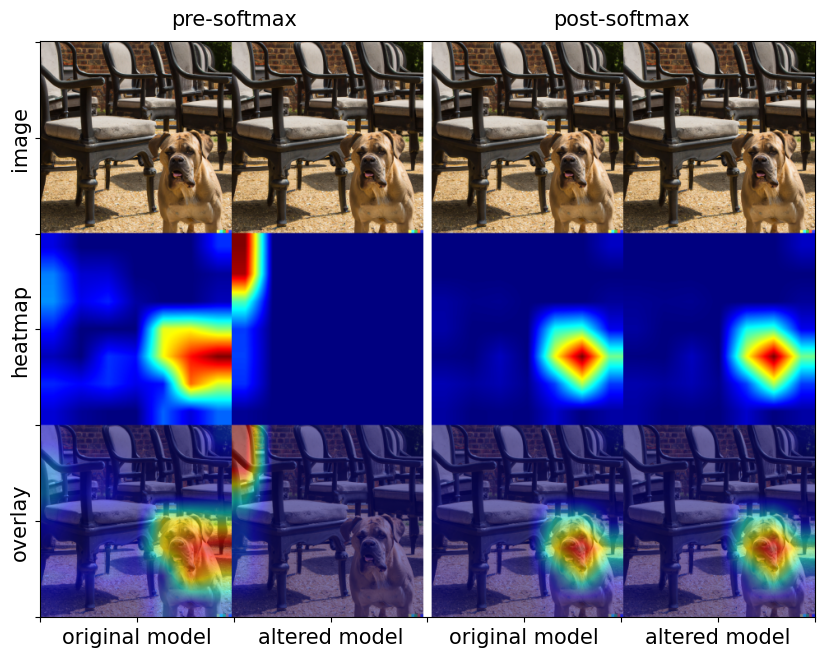


time: 1.28 s (started: 2023-07-06 19:35:40 +00:00)


In [23]:

orig_image = images_dir + 'dog-chairs.png'
orig_image
display_heatmaps(orig_image,layerName, save_plot=True, plot_name='dog-and-chairs_plot.png')


layerName = block5_pool

1/1 [==============================] - 0s 24ms/step

Original Model
0 - ('n02106662', 'German_shepherd', 9.969507) - 0.7797225117683411
1 - ('n02105162', 'malinois', 7.589122) - 0.07213596254587173
2 - ('n02109047', 'Great_Dane', 7.4768014) - 0.06447207927703857
3 - ('n03803284', 'muzzle', 6.664317) - 0.028609761968255043
4 - ('n02115641', 'dingo', 6.053223) - 0.015528143383562565
5 - ('n02091467', 'Norwegian_elkhound', 5.59541) - 0.009824121370911598
6 - ('n02105412', 'kelpie', 5.451004) - 0.008503135293722153
7 - ('n02107142', 'Doberman', 5.449865) - 0.008493454195559025
8 - ('n02124075', 'Egyptian_cat', 5.277535) - 0.0071489522233605385
9 - ('n02110806', 'basenji', 5.026503) - 0.0055618672631680965

New Model
0 - ('n02106662', 'German_shepherd', 220630.12) - 0.7787927985191345
1 - ('n02105162', 'malinois', 220627.75) - 0.07243901491165161
2 - ('n02109047', 'Great_Dane', 220627.64) - 0.06493391841650009
3 - ('n03803284', 'muzzle', 220626.83) - 0.0288142524659

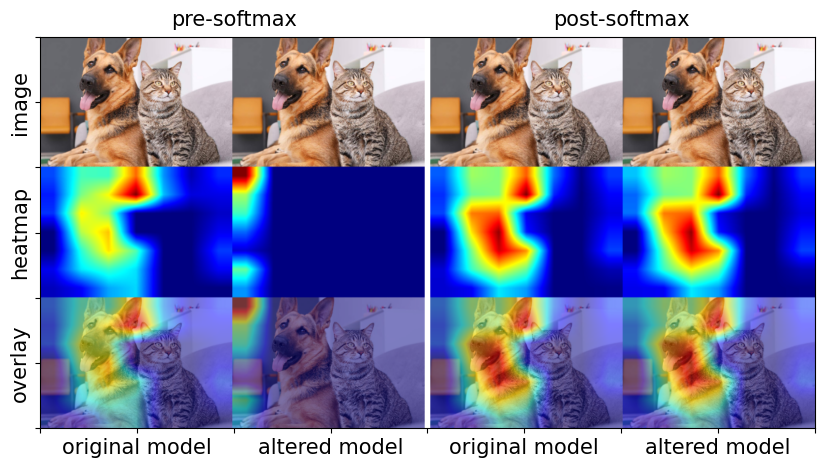


time: 1.1 s (started: 2023-07-06 19:35:42 +00:00)


In [24]:
orig_image = images_dir + 'dog-and-cat.jpg'
orig_image
display_heatmaps(orig_image,layerName, save_plot=True, plot_name='dog-and-cat_plot.png')

layerName = block5_pool

1/1 [==============================] - 0s 23ms/step

Original Model
0 - ('n02108422', 'bull_mastiff', 11.702841) - 0.42894843220710754
1 - ('n02108089', 'boxer', 11.119274) - 0.23931242525577545
2 - ('n02129604', 'tiger', 10.885994) - 0.18951910734176636
3 - ('n02123159', 'tiger_cat', 9.76954) - 0.062055908143520355
4 - ('n02109047', 'Great_Dane', 9.008847) - 0.029001370072364807
5 - ('n02110958', 'pug', 8.496576) - 0.01737569086253643
6 - ('n02087394', 'Rhodesian_ridgeback', 8.310446) - 0.014424695633351803
7 - ('n02088466', 'bloodhound', 7.7971497) - 0.008633461780846119
8 - ('n03803284', 'muzzle', 7.386652) - 0.0057267481461167336
9 - ('n02093428', 'American_Staffordshire_terrier', 7.2513876) - 0.005002228077501059

New Model
0 - ('n02108422', 'bull_mastiff', 241219.38) - 0.42802882194519043
1 - ('n02108089', 'boxer', 241218.8) - 0.2401023954153061
2 - ('n02129604', 'tiger', 241218.56) - 0.18993663787841797
3 - ('n02123159', 'tiger_cat', 241217.44) - 0.06166

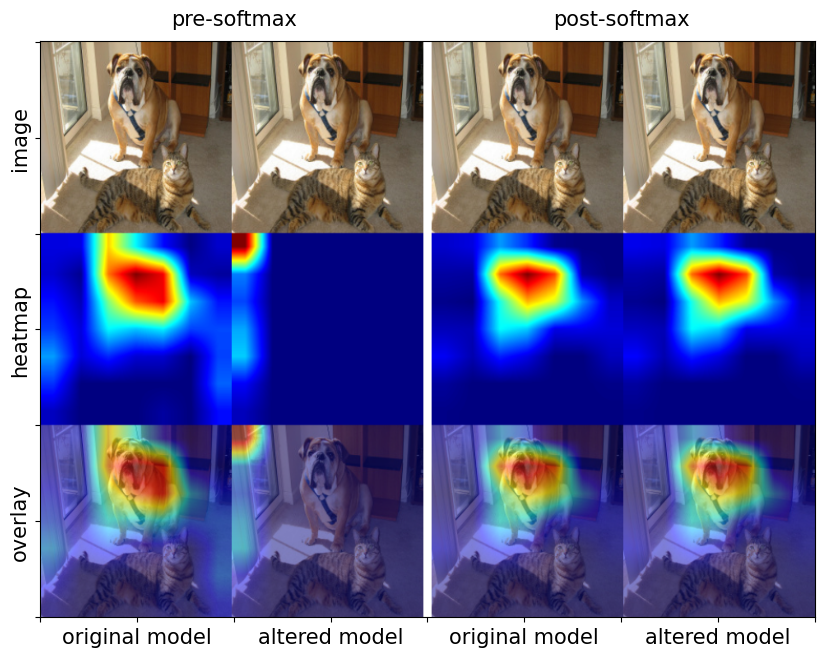


time: 743 ms (started: 2023-07-06 19:35:43 +00:00)


In [25]:
orig_image = images_dir + 'dog.jpg'
orig_image
display_heatmaps(orig_image,layerName)

layerName = block5_pool

1/1 [==============================] - 0s 33ms/step

Original Model
0 - ('n13133613', 'ear', 23.440025) - 0.8863343000411987
1 - ('n12144580', 'corn', 21.050976) - 0.08129175752401352
2 - ('n03884397', 'panpipe', 20.126373) - 0.032247550785541534
3 - ('n07753592', 'banana', 13.659727) - 5.01265749335289e-05
4 - ('n03372029', 'flute', 13.473184) - 4.159615855314769e-05
5 - ('n03840681', 'ocarina', 12.442314) - 1.4837210983387195e-05
6 - ('n07615774', 'ice_lolly', 12.304549) - 1.2927713214594405e-05
7 - ('n04579432', 'whistle', 10.76313) - 2.767527348623844e-06
8 - ('n01748264', 'Indian_cobra', 10.762992) - 2.7671449061017483e-06
9 - ('n03494278', 'harmonica', 10.0688505) - 1.382197524435469e-06

New Model
0 - ('n13133613', 'ear', 264355.9) - 0.8852831721305847
1 - ('n12144580', 'corn', 264353.53) - 0.0823441594839096
2 - ('n03884397', 'panpipe', 264352.6) - 0.032246436923742294
3 - ('n07753592', 'banana', 264346.12) - 5.001949466532096e-05
4 - ('n03372029', 'flu

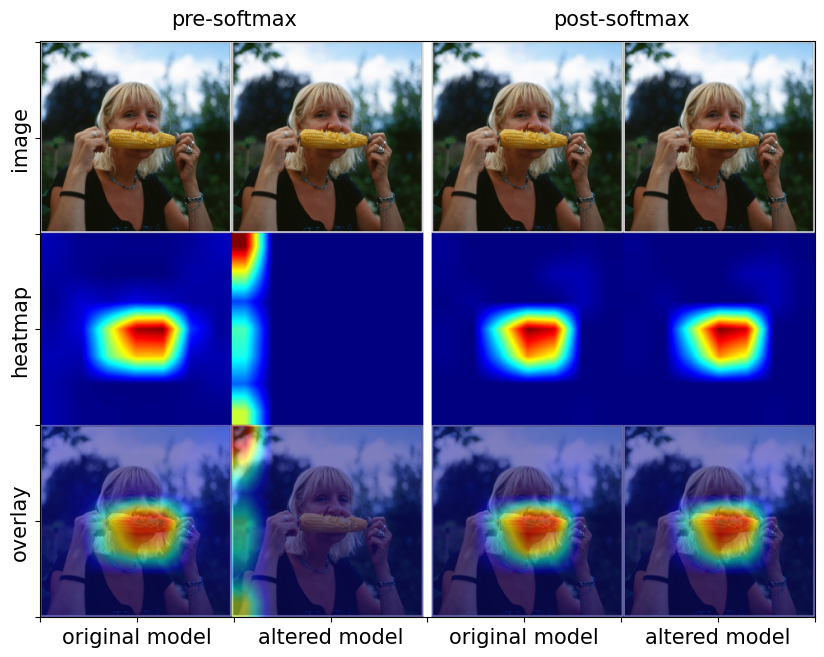


time: 1.15 s (started: 2023-07-06 19:36:23 +00:00)


In [27]:
orig_image = images_dir + 'corn.jpg'
orig_image
display_heatmaps(orig_image,layerName,save_plot=True, plot_name='corn_plot.png')

layerName = block5_pool

1/1 [==============================] - 0s 23ms/step

Original Model
0 - ('n02124075', 'Egyptian_cat', 13.972017) - 0.9139493107795715
1 - ('n02441942', 'weasel', 10.789231) - 0.037901438772678375
2 - ('n02123045', 'tabby', 10.526357) - 0.029140081256628036
3 - ('n02123159', 'tiger_cat', 9.311964) - 0.008651405572891235
4 - ('n02443484', 'black-footed_ferret', 8.491925) - 0.003810205264016986
5 - ('n02442845', 'mink', 7.641864) - 0.0016284385928884149
6 - ('n02443114', 'polecat', 7.625295) - 0.001601679832674563
7 - ('n02127052', 'lynx', 7.563206) - 0.001505257561802864
8 - ('n01675722', 'banded_gecko', 7.1176624) - 0.0009640812058933079
9 - ('n02356798', 'fox_squirrel', 6.9895353) - 0.0008481423137709498

New Model
0 - ('n02124075', 'Egyptian_cat', 241837.78) - 0.9133173823356628
1 - ('n02441942', 'weasel', 241834.61) - 0.038290753960609436
2 - ('n02123045', 'tabby', 241834.34) - 0.02935853973031044
3 - ('n02123159', 'tiger_cat', 241833.12) - 0.0086783673614263

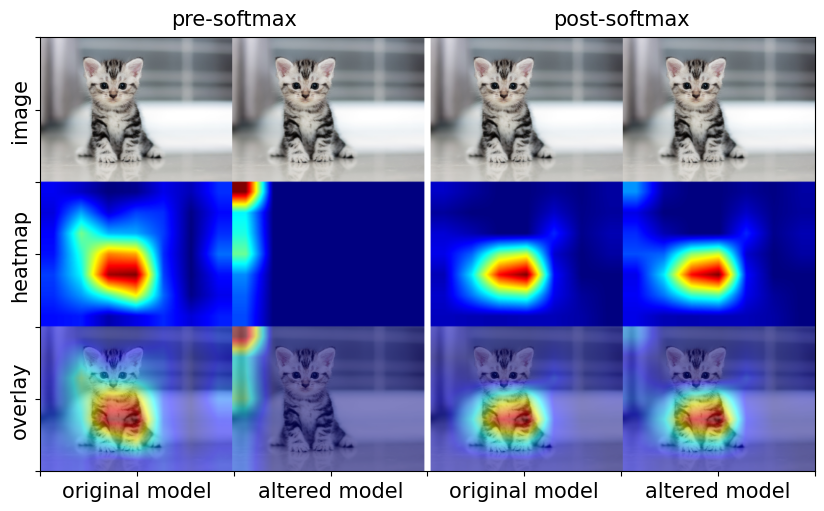


time: 3.58 s (started: 2023-07-06 19:36:28 +00:00)


In [28]:
orig_image = images_dir + 'amer_cat.jpg'
orig_image
display_heatmaps(orig_image,layerName, save_plot=True, plot_name='amer_cat_plot.png')

layerName = block5_pool

1/1 [==============================] - 0s 25ms/step

Original Model
0 - ('n01592084', 'chickadee', 15.592245) - 0.37191441655158997
1 - ('n01534433', 'junco', 15.272053) - 0.27001336216926575
2 - ('n01580077', 'jay', 15.194865) - 0.24995577335357666
3 - ('n01582220', 'magpie', 13.144439) - 0.0321643091738224
4 - ('n01558993', 'robin', 12.74451) - 0.021561911329627037
5 - ('n01537544', 'indigo_bunting', 12.730474) - 0.02126139961183071
6 - ('n01601694', 'water_ouzel', 12.434757) - 0.015818433836102486
7 - ('n01795545', 'black_grouse', 12.142738) - 0.01181248389184475
8 - ('n01532829', 'house_finch', 10.992315) - 0.0037386855110526085
9 - ('n01530575', 'brambling', 10.238428) - 0.0017591783544048667

New Model
0 - ('n01592084', 'chickadee', 294635.97) - 0.37183234095573425
1 - ('n01534433', 'junco', 294635.66) - 0.2720383405685425
2 - ('n01580077', 'jay', 294635.56) - 0.2476937472820282
3 - ('n01582220', 'magpie', 294633.53) - 0.03249034658074379
4 - ('n01558993'

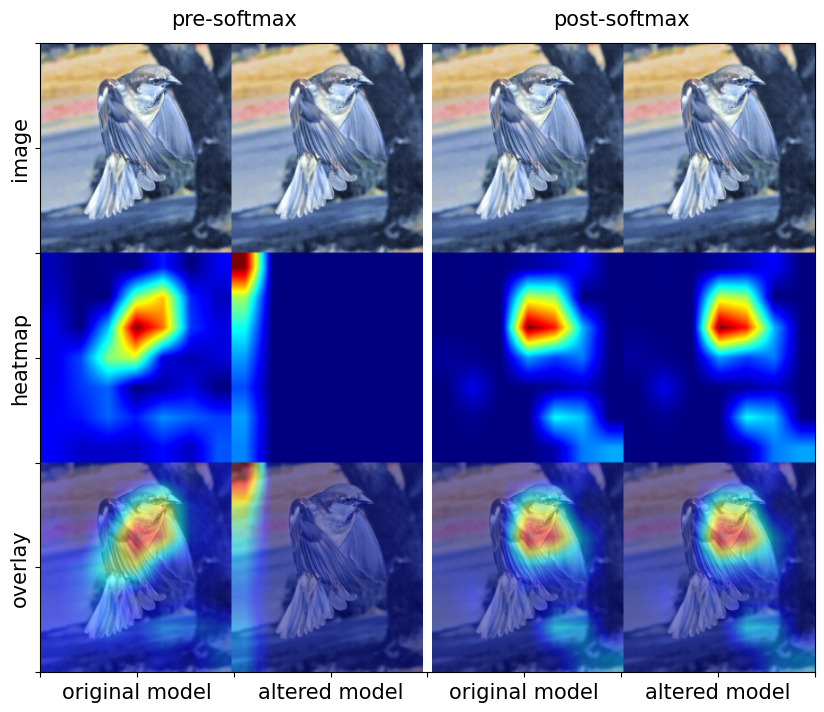


time: 1.12 s (started: 2023-07-06 19:36:37 +00:00)


In [29]:
orig_image = images_dir + 'bird_002316.jpg'
orig_image
display_heatmaps(orig_image,layerName, save_plot=True, plot_name='bird_plot_plot.png')